# Set Trading

Strategy: Find closely correlated stocks among the top 50 market cap companies and separate into a variable number of groups using clustering. Implement a moving average strategy. 

Generate buy and sell indicators using LSTM model. If a threshold number of companies in a group have a certain indicator, follow that indicator for all companies in the group. 

## 1. Clustering

In [1]:
# IMPORTS
import math
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

#### List of top 50 market cap stocks

In [2]:
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BRK-A', 'UNH', 'XOM', 
         'JNJ', 'V', 'WMT', 'JPM', 'CVX', 'LLY', 'NVDA', 'TSM',
         'PG', 'MA', 'HD', 'BAC', 'PFE', 'ABBV', 'KO', 'MRK', 'PEP',
          'META', 'COST', 'ORCL', 'TMO', 'MCD', 'AVGO', 'DIS', 'TM',
          'NVO', 'ACN', 'ASML', 'TMUS', 'CSCO', 'DHR', 'AZN', 'NVS', 'WFC',
          'ABT', 'BABA', 'BMY', 'CRM', 'COP', 'VZ', 'NEE', 'SCHW']

print(len(stocks))

50


#### Downloading data for stocks in list from Yahoo Finance

In [3]:
df = yf.download(stocks, start="2015-01-01", end="2022-11-01")
df

[*********************100%***********************]  50 of 50 completed


Adj Close                                                 \
                  AAPL        ABBV        ABT         ACN        AMZN   
Date                                                                    
2015-01-02   24.603207   46.979839  38.606464   77.739204   15.426000   
2015-01-05   23.910095   46.095718  38.615059   76.426628   15.109500   
2015-01-06   23.912344   45.867550  38.176540   75.875351   14.764500   
2015-01-07   24.247650   47.721367  38.486092   77.467949   14.921000   
2015-01-08   25.179298   48.220463  39.277138   78.649246   15.023000   
...                ...         ...        ...         ...         ...   
2022-10-25  152.087708  149.820007  97.949997  280.609985  120.599998   
2022-10-26  149.102661  152.509995  98.419998  279.869995  115.660004   
2022-10-27  144.560196  153.500000  96.930000  278.839996  110.959999   
2022-10-28  155.482086  147.610001  99.489998  287.779999  103.410004   
2022-10-31  153.086044  146.399994  98.940002  283.899994  102.440002   

                                                                      ...  \
                  ASML        AVGO        AZN        BABA        BAC  ...   
Date                                                                  ...   
2015-01-02   99.025742   79.733505  26.467314  103.599998  15.456274  ...   
2015-01-05   95.697227   78.458916  26.264303  101.000000  15.007262  ...   
2015-01-06   92.866608   76.674507  25.625177  103.320000  14.558255  ...   
2015-01-07   93.392151   78.745705  25.598858  102.129997  14.627333  ...   
2015-01-08   95.346840   82.681000  25.967299  105.029999  14.929555  ...   
...                ...         ...        ...         ...        ...  ...   
2022-10-25  484.550873  460.070007  55.900002   63.220001  35.389999  ...   
2022-10-26  482.636627  461.179993  57.959999   68.510002  35.700001  ...   
2022-10-27  472.985687  455.399994  57.610001   65.839996  35.869999  ...   
2022-10-28  487.711334  472.899994  58.709999   63.740002  36.180000  ...   
2022-10-31  471.001678  470.119995  58.810001   63.580002  36.040001  ...   

             Volume                                                   \
                TMO      TMUS      TSLA       TSM      UNH         V   
Date                                                                   
2015-01-02  2034700   3515300  71466000   6074100  3060900   8389600   
2015-01-05  2430300   3477300  80527500   9031800  4679000  12751200   
2015-01-06  2519300   4237100  93928500  10169500  3468300  11070000   
2015-01-07  2098300   7528300  44526000  10180200  3225800   9346800   
2015-01-08  2515800   6715900  51637500  15825900  5346100  10443200   
...             ...       ...       ...       ...      ...       ...   
2022-10-25  2382800   5738500  96507900  21700600  2411900  11907200   
2022-10-26  2446900   6662300  85012500  14006000  2863500  15450000   
2022-10-27  2334800   7425300  61638800  12937600  2212100   7946700   
2022-10-28  2017100  13902800  69152400  11972300  2761900   8455600   
2022-10-31  2875200   8396000  61554300  10802800  2770400   8674100   

                                                    
                  VZ       WFC       WMT       XOM  
Date                                                
2015-01-02  11421200  11700900   4501800  10220400  
2015-01-05  18964500  15000500   6979000  18502400  
2015-01-06  22950100  20211200   8205100  16670700  
2015-01-07  20793600  15714700   8498400  13590700  
2015-01-08  17617500  16721600  12713600  15487500  
...              ...       ...       ...       ...  
2022-10-25  25496500  16362200   5017100  15719800  
2022-10-26  20328200  15010800   6918100  17383800  
2022-10-27  20268000  14655500   5534300  18214000  
2022-10-28  31824300  14990400   4549400  28169400  
2022-10-31  26630600  14000000   7524000  26401800  

[1972 rows x 300 columns]

In [4]:
X = df['Adj Close']

#### Using a correlation matrix, we can find/visualize closely correlated stocks 

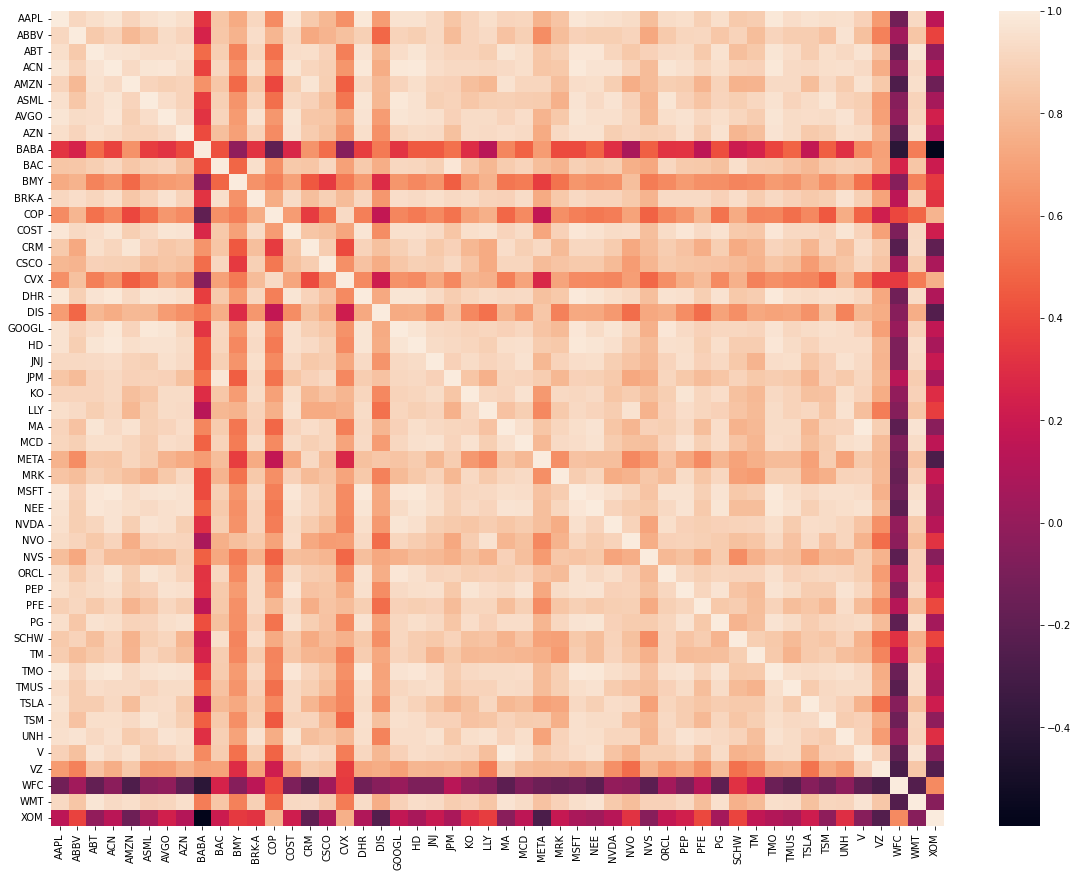

In [5]:
corr = X.corr() # Get the correlation matrix
plt.figure(figsize = (20, 15))
sns.heatmap(corr) # Although it is called heatmap here, it nonetheless shows the pairwise correlation between features.
plt.show()

In [6]:
sort = corr['AAPL'].sort_values(ascending = False)
sort

AAPL     1.000000
TMO      0.985326
DHR      0.982348
MSFT     0.980021
COST     0.975337
AVGO     0.971483
ACN      0.969703
GOOGL    0.961322
NEE      0.960219
TSLA     0.960216
HD       0.958642
UNH      0.955019
ASML     0.953868
NVDA     0.952319
TSM      0.949785
AZN      0.949643
ABT      0.949551
PG       0.949072
PEP      0.947873
LLY      0.944331
TMUS     0.943615
ORCL     0.936158
NVO      0.932887
WMT      0.921718
JNJ      0.919996
ABBV     0.917707
BRK-A    0.917512
MCD      0.906669
KO       0.905527
MA       0.901963
AMZN     0.900621
V        0.889551
PFE      0.882086
TM       0.871564
CRM      0.861609
SCHW     0.861587
BAC      0.844240
JPM      0.840793
MRK      0.836666
NVS      0.809602
CSCO     0.782232
META     0.766497
BMY      0.733635
DIS      0.679493
VZ       0.672801
CVX      0.638135
COP      0.617091
BABA     0.323660
XOM      0.144643
WFC     -0.132706
Name: AAPL, dtype: float64

In [7]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance

#### Using linkage, fcluster and dendrogram, we cluster stocks based on their correlation and their respective "distances" from each other

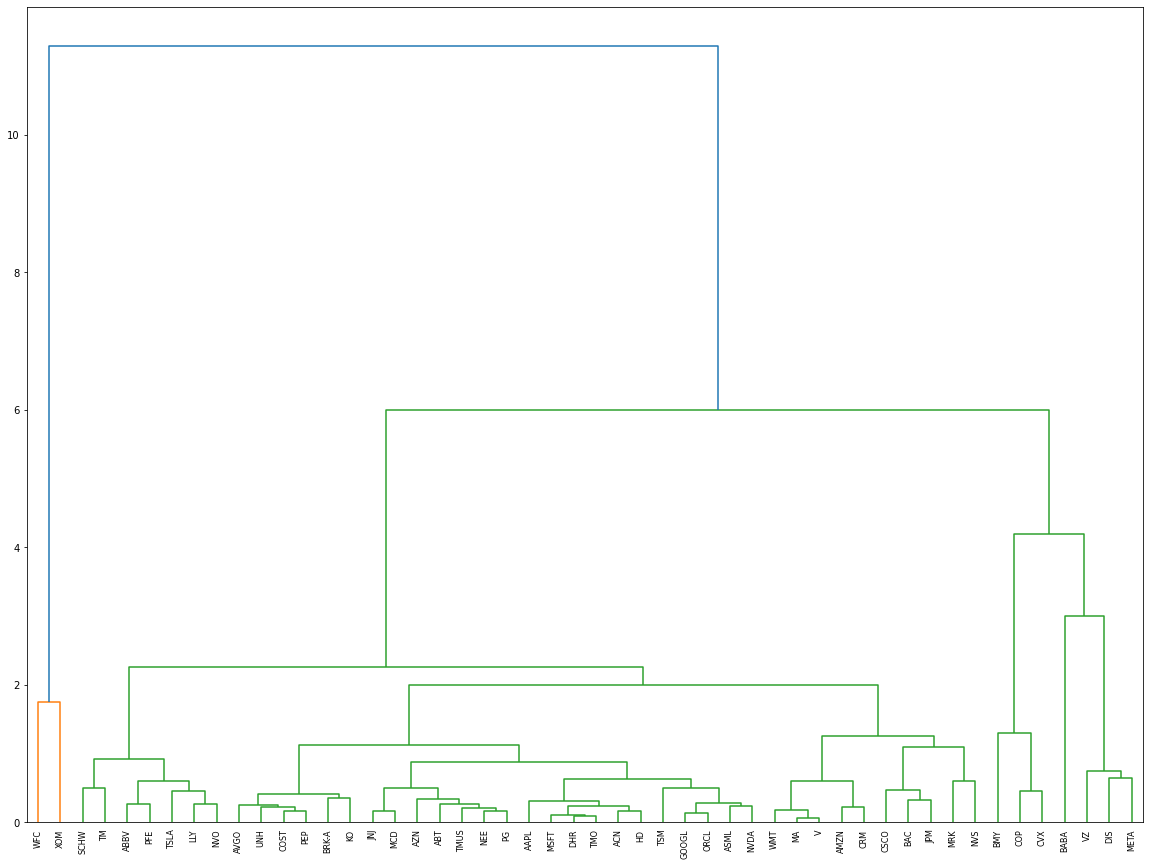

In [8]:
corr_values = np.asarray(corr.values)

plt.figure(figsize = (20, 15))
dist = linkage(distance.pdist(corr_values), method = 'ward')

dn = dendrogram(dist, labels=X.columns)
plt.show()
threshold = 4

labels = fcluster(dist, threshold, criterion='distance')

In [9]:
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 3, 2, 2, 2, 3, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 1, 2, 1], dtype=int32)

## 2. Using LSTM model to predict stock prices
We chose to use an LSTM model because it is capable of processing sequences of time-series data, learning long-term dependecies and generating future predictions.

#### Import libraries

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

#### Preparing the data
We want to predict the close price of a stock using the most recent n open prices. This function splits the passed in open price data into arrays of n previous prices for time stamp.

In [11]:
def split_data(data, n):
    X = []
    for i in range(len(data)-n+1):
        X.append([data[i:i+n,]])
    return np.array(X)

#### Designing & Fitting the Model
This function creates an LSTM model to predict close prices for each a stock specified by its ticker. It is written as a function because we want to do this for each stock we are observing. 

- Uses Standard Scaler to rescale data. This prevents features with larger values to incorrectly influence the model.

- Manually splits the data rather than using train_test_split to ensure that the test data comes after the train data in time

- Returns the predicted and true values of the test set

In [12]:
def predict_price(ticker):
    open_prices = pd.DataFrame([df['Open'][ticker]])
    open_prices = open_prices.transpose()
    open_prices.columns = ['Open']

    # Scale data
    sc = StandardScaler()
    X_ft = sc.fit_transform(open_prices.values)
    X_ft = pd.DataFrame(columns=open_prices.columns, data=X_ft, index = open_prices.index)
    X_ft = X_ft.reset_index()
    X_ft = X_ft['Open']
    
    X = split_data(X_ft.values, n = 5)

    Y = pd.DataFrame(df['Close'][ticker])
    Y = Y.reset_index()
    Y = Y[ticker]
    
    # Split into train and test splits
    train_split = 0.8
    split = int(np.ceil(len(X)*train_split))

    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]
    
    # Build model
    model = Sequential()
    model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train model on train set
    history = model.fit(X_train, Y_train, epochs=25, batch_size=4, verbose=0, shuffle=False)
    
    # Create predicted and actual value arrays to return
    Y_pred = model.predict(X_test)
    predictions = []
    for i in range(len(Y_pred)):
        predictions.append(Y_pred[i][0][0])
    
    actual = pd.DataFrame(df['Close'][ticker])
    actual = actual[len(actual) - len(predictions):]
    actual = actual.reset_index()
    dates = actual['Date']
    actual = actual[ticker]
    actual = actual[len(actual) - len(predictions):]
    
    return predictions, actual

#### Predict close prices for each stock

In [13]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BRK-A'] # found to be in a group using clustering
predict_map = {}
actual_map = {}
for t in tickers:
    pred, act = predict_price(t)
    predict_map[t] = pred
    actual_map[t] = act

2022-11-30 21:19:12.891540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 0s 1ms/step


#### Visualizing predictions
We plotted the actual and predicted close prices for a few stocks to visualize the model's performance.

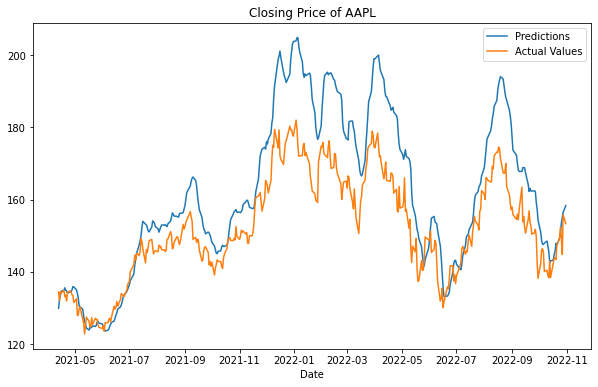

In [14]:
plt_ticker = 'AAPL'
plt.figure(figsize=(10,6))
actual = pd.DataFrame(df['Close'][plt_ticker])
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
actual = actual.reset_index()
dates = actual['Date']
actual = actual[plt_ticker]
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
plt.plot(dates, predict_map[plt_ticker])
plt.plot(dates, actual)
plt.xlabel('Date')
plt.title(f'Closing Price of {plt_ticker}')
plt.legend(["Predictions","Actual Values"])

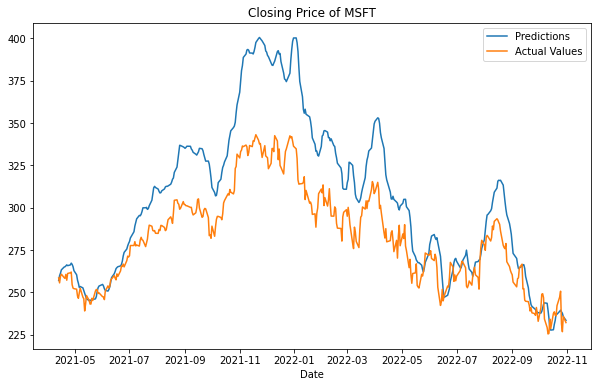

In [15]:
plt_ticker = 'MSFT'
plt.figure(figsize=(10,6))
actual = pd.DataFrame(df['Close'][plt_ticker])
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
actual = actual.reset_index()
dates = actual['Date']
actual = actual[plt_ticker]
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
plt.plot(dates, predict_map[plt_ticker])
plt.plot(dates, actual)
plt.xlabel('Date')
plt.title(f'Closing Price of {plt_ticker}')
plt.legend(["Predictions","Actual Values"])

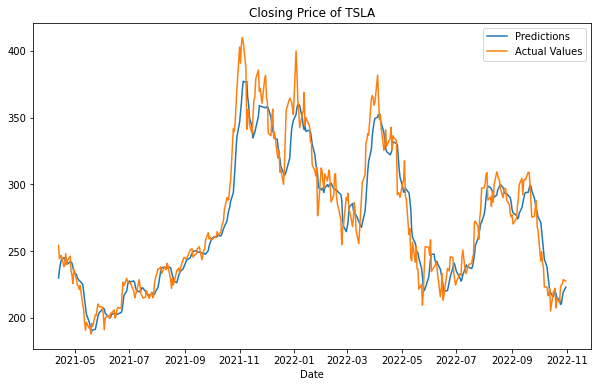

In [16]:
plt_ticker = 'TSLA'
plt.figure(figsize=(10,6))
actual = pd.DataFrame(df['Close'][plt_ticker])
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
actual = actual.reset_index()
dates = actual['Date']
actual = actual[plt_ticker]
actual = actual[len(actual) - len(predict_map[plt_ticker]):]
plt.plot(dates, predict_map[plt_ticker])
plt.plot(dates, actual)
plt.xlabel('Date')
plt.title(f'Closing Price of {plt_ticker}')
plt.legend(["Predictions","Actual Values"])

In [17]:
print(dates)

0     2021-04-13
1     2021-04-14
2     2021-04-15
3     2021-04-16
4     2021-04-19
         ...    
388   2022-10-25
389   2022-10-26
390   2022-10-27
391   2022-10-28
392   2022-10-31
Name: Date, Length: 393, dtype: datetime64[ns]


## 3. Mean Reversion Trading Strategy
Based on the assumption that stocks will "revert" back to their mean price.

Strategy function generates buy and sell indicators based on whether the LSTM model predicted price is out of range of a specific threshold number of standard deviations from the mean.

In [18]:
#group: array of string names in group
#data: dataframe with data corresponding to stock name
def strategy(group, data, z, actual, predict):
  buysell = []
  for i in range(len(predict[group[0]])):
    sum = 0
    for stock in group:
      stdev = np.std(actual[stock])
      mean = np.mean(actual[stock])
      if(predict[stock][i] < mean - z * stdev):
        sum -= 1
      elif(predict[stock][i] > mean + z * stdev):
        sum += 1
    avg = sum / len(group)
    if avg > 0.5:
      buysell.append(1)
    else:
      buysell.append(-1)
  return buysell

In [19]:
Y = pd.DataFrame(df['Close'])
Y = Y.reset_index()
strat = strategy(tickers, Y, 1, actual_map, predict_map)

#### Backtest predictions
Calculates profit if we were to implement this strategy in the test period. According to buy and sell indicators from strategy function, either buy another unit of every stock in the group, or sell a unit of every stock in the group

In [20]:
#test_data: df of data corresponding to the sum of prices of a group
def backtest(test_data, buysell):
  units = 0
  profit = 0
  init = 0
  for i in range(len(buysell)):
    if(buysell[i] == 1):
      units += 1
      profit -= test_data[i]
      if init == 0:
        init += test_data[i]
    elif(buysell[i] == -1):
      if(units >= 1):
        units -=1
        profit += test_data[i]
  return profit, init

#### Sum up data for all tickers in a group.

In [21]:
def sumGroup(group, data):
  sums = []
  for i in range(len(data)):
    sum = 0
    for stock in group:
      sum += data[stock][i]
    sums.append(sum)
  return sums

In [22]:
actual = pd.DataFrame(actual_map)
print(actual)
group_1 = sumGroup(tickers, actual)

           AAPL        MSFT       GOOGL        AMZN        TSLA     BRK-A
0    134.429993  258.489990  112.721497  170.000000  254.106674  402500.0
1    132.029999  255.589996  112.095497  166.649994  244.076660  403000.0
2    134.500000  259.500000  114.262497  168.954498  246.283340  404789.0
3    134.160004  260.739990  114.137497  169.972000  246.593338  409250.0
4    134.839996  258.739990  114.487999  168.600494  238.210007  406505.0
..          ...         ...         ...         ...         ...       ...
388  152.339996  250.660004  104.480003  120.599998  222.419998  436400.0
389  149.350006  231.320007   94.930000  115.660004  224.639999  435660.0
390  144.800003  226.750000   92.220001  110.959999  225.089996  437900.0
391  155.740005  235.869995   96.290001  103.410004  228.520004  451900.0
392  153.339996  232.130005   94.510002  102.440002  227.539993  445050.0

[393 rows x 6 columns]


#### Potential profit over the span of a year and a half(0.2 * total length of data)

In [23]:
profit, init_invest = backtest(group_1, strat)
print("Profit: " + str(profit))
print("Initial Investment: " + str(init_invest))

Profit: 200442.26113891602
Initial Investment: 436114.5506591797


Pretty good returns given the volatility of the market in the past 2 years!